# Validate `alfresco_relative_flammability.py`

This notebook is for validating results from the `alfresco_relative_flammability.py` script. This script is intended to produce relative flammability estimates from ALFRESCO outputs. 

The approach taken is to 

1. manually compute relative flammability here
2. use the script on the same outputs
3. verify that the results from each are the same

## Testing set

The data used to test this are currently in `/atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated/`. 

## Compute relative flammability

According to [SNAP CKAN description](http://ckan.snap.uaf.edu/dataset/alfresco-model-outputs-relative-flammability), relative flammability "Counts the number of times a pixel burned through all replicates and time and divides that value by the total number of layers (replicates * years)"

So to implement this for a single century (100 years) for all replicates (200), relative flammability for a single pixel is computed as:

$$n / 100 * 200$$

Where $n$ is the total number of times a pixel burned across all replicates and time.

#### Input data: fire scar

It looks like number of fires for a pixel can be derived from fire scar files. According to this [JFSP report](https://drive.google.com/file/d/17bLAPkfq5i8dlrrBXmQNHvgoGspM3jRS/view?usp=sharing), band 3 is a boolean for ignition. Verify this with a sample file, rep 1 of year 2005:

In [1]:
import os
import subprocess
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import tqdm
from multiprocessing import Pool

In [2]:
# setup paths
base_dir = Path("/atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated/")
scratch_dir = Path("/atlas_scratch/kmredilla/aalfresco")

In [3]:
model = "CCSM4"
scenario = "rcp45"

temp_scar_fn = f"{model}_{scenario}_NoFMO/Maps/{{}}/FireScar_{{}}_{{}}.tif"

In [4]:
year = "2005"
rep = "1"

fp = base_dir.joinpath(temp_scar_fn.format(year, rep, year))

Band 1 should be only the year of burning. Unique values: 

In [44]:
with rio.open(fp) as src:
    print(np.unique(src.read(1)))

[-2147483647        2005]


Band 2 should be burn ID. Unique values:

In [45]:
with rio.open(fp) as src:
    print(np.unique(src.read(2)))

[-2147483647           1           2           3           4           5
           6           7           8           9          10          11
          12          13          14          15          16          17
          18          19          20          21          22          23
          24          25          26          27          28          29
          30          31          32          33          34          35
          36          37          38          39          40          41
          42          43          44          45          46          47
          48          49          50          51          52          53
          54          55          56          57          58          59
          60          61          62          63          64          65
          66          67          68          69          70          71
          72          73          74          75          76          77
          78          79          80          81   

Band 3 should be boolean for burn/no burn. Unique values:

[ 0.  1. nan]
Plot:


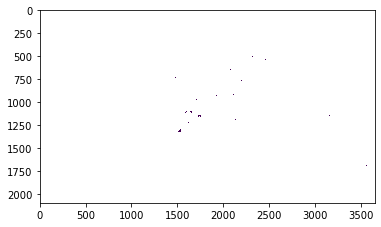

In [46]:
with rio.open(fp) as src:
    temp_arr = src.read(3).astype(float)
    temp_arr[temp_arr == src.meta["nodata"]] = np.nan
    print(np.unique(temp_arr))
    print("Plot:")
    plt.imshow(temp_arr, interpolation="none")

Zoom in on an area:

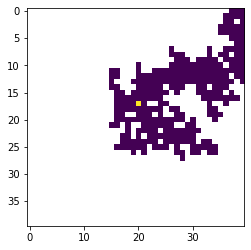

In [52]:
plt.imshow(temp_arr[1100:1140, 1560:1600], interpolation="none")

You can see this fire started with the yellow pixel and burned over all of the blue pixels. This confirms burn number can be derived from fire scar outputs - any pixel with data burned in that particular rep/year.

#### Compute relative flammability

Using these data, compute that relative flammability data. 

In [30]:
periods = {
    "1900-1999": np.arange(1901, 2000),
    "2000-2099": np.arange(2000, 2101),
}

In [31]:
model = "CCSM4"
scenario = "rcp45"

In [84]:
def read_burn(fp):
    with rio.open(fp) as src:
        temp_arr = src.read(3, masked=True)
        return (~temp_arr.mask)

    
# extract the data in prallel
# init empty counting array
total_arr = np.zeros((2100, 3650)).astype(int)

tic = time.perf_counter()

for year in periods["1900-1999"]:
    fps = list(base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps/").glob(f"{year}/FireScar*.tif"))

    with Pool(30) as pool:
        # chunk up printing a little bit
        if (year % 10 == 0) or (year == 1901):
            print(f"working on {year}'s")
            burn_arrs = [arr for arr in tqdm.tqdm(pool.imap_unordered(read_burn, fps), total=len(fps))]
        else:
            burn_arrs = pool.map(read_burn, fps)

    total_arr += np.sum(burn_arrs, axis=0)

et = round(time.perf_counter() - tic)
print(f"Elapsed time to count all burns: {et}s")

working on 1901's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.58it/s]


working on 1910's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.87it/s]


working on 1920's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.77it/s]


working on 1930's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.54it/s]


working on 1940's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.31it/s]


working on 1950's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.83it/s]


working on 1960's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.49it/s]


working on 1970's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.42it/s]


working on 1980's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.69it/s]


working on 1990's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.34it/s]


Elapsed time to count all burns: 789s


In [102]:
# compute relative flammability
relflam_arr = total_arr.astype(np.float32) / (len(fps) * len(periods["1900-1999"]))

Relative flammability of domain:

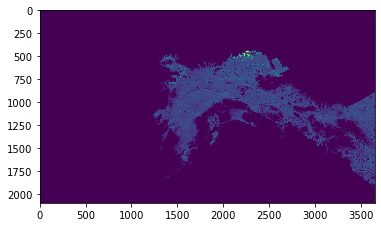

In [104]:
plt.imshow(relflam_arr, interpolation="none")

Looks reasonable. Counts of burns:

(array([6.551746e+06, 5.436220e+05, 5.428540e+05, 1.884100e+04,
        3.607000e+03, 1.895000e+03, 9.680000e+02, 6.660000e+02,
        5.360000e+02, 2.650000e+02]),
 array([  0. ,  59.6, 119.2, 178.8, 238.4, 298. , 357.6, 417.2, 476.8,
        536.4, 596. ]),
 <BarContainer object of 10 artists>)

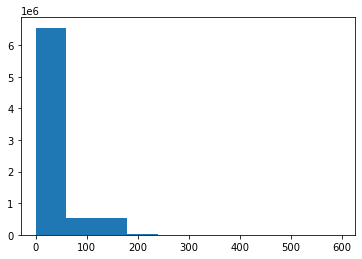

In [105]:
plt.hist(total_arr.flatten())

In [86]:
# write the results
out_fp = scratch_dir.joinpath(f"alf_relflam_manual_{model}_{scenario}_1900_1999.tif")

In [117]:
# to match the script, need to read in mask from veg file and apply it
mask = rio.open(str(fps[0]).replace("FireScar_", "Veg_")).read_masks(1)
mask = (mask == 255).astype(int)
mask_value = -9999.0
relflam_arr[mask == 0] = mask_value

In [118]:
# get metadata from an input fp
with rio.open(fp) as src:
    meta = src.meta.copy()

meta.update({"dtype": "float32", "nodata": mask_value})

# rounded to 4 decimal places in script
with rio.open(out_fp, "w", **meta) as dst:
    dst.write(np.around(relflam_arr, 4), 1)

## Compute using `alfresco_relative_flammability.py` script

Now apply the `alfresco_relative_flammability.py` to the same model / scenario and years.

In [11]:
maps_path = base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps/")
ncores = "30"
begin_year = "1900"
end_year = "1999"
output_filename = scratch_dir.joinpath(f"alf_relflam_test_{model}_{scenario}_{begin_year}_{end_year}.tif")

In [12]:
script_run = os.system((
    "cd "
    "../bin/ "
    "&& "
    "python " 
    "alfresco_relative_flammability.py "
    "-p "
    f"{maps_path} "
    "-o "
    f"{output_filename} "
    "-nc "
    f"{ncores} "
    "-by "
    f"{begin_year} "
    "-ey "
    f"{end_year}"
))

running firescar groups summation
group 10  done
group 0  done
group 101  done
group 105  done
group 107  done
group 110  done
group 103  done
group 112  done
group 114  done
group 118  done
group 136  done
group 127  done
group 141  done
group 12  done
group 145  done
group 132  done
group 134  done
group 121  done
group 116  done
group 125  done
group 138  done
group 109  done
group 129  done
group 123  done
group 147  done
group 150  done
group 14  done
group 149  done
group 130  done
group 143  done
group 100  done
group 1  done
group 106  done
group 108  done
group 102  done
group 111  done
group 104  done
group 113  done
group 115  done
group 120  done
group 142  done
group 119  done
group 137  done
group 133  done
group 128  done
group 139  done
group 122  done
group 117  done
group 135  done
group 126  done
group 146  done
group 148  done
group 13  done
group 151  done
group 15  done
group 11  done
group 131  done
group 124  done
group 140  done
group 144  done
group 152  done


## Compare the results

Compare the results from both approaches:

In [120]:
with rio.open(out_fp) as src1:
    with rio.open(output_filename) as src2:
        print("Relative flammability arrays match: ", np.all(src1.read(1) == src2.read(1)))

Relative flammability arrays match:  True


The script appears to be valid. 